# Download BDTRE database from the Geoportal of the Piemonte region, Italy

## Install packages if necessary

In [128]:
#install.packages("progress")
#install.packages("sf")

Warning message:
“unable to access index for repository https://cran.r-project.org/src/contrib:
  impossibile aprire URL 'https://cran.r-project.org/src/contrib/PACKAGES'”
Warning message:
“package ‘progressr’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Warning message:
“unable to access index for repository https://cran.r-project.org/bin/macosx/contrib/4.0:
  impossibile aprire URL 'https://cran.r-project.org/bin/macosx/contrib/4.0/PACKAGES'”


## Open the library

In [1]:
library(progress)
library(sf)

Linking to GEOS 3.8.1, GDAL 3.1.4, PROJ 6.3.1



## Get municipality identification codes

In [7]:
get_municipality_codes <- function() {
    
    # download the csv table from the ISTAT website (the link should be permanent)
    data <- read.csv("https://www.istat.it/storage/codici-unita-amministrative/Elenco-comuni-italiani.csv", 
                     header=FALSE, stringsAsFactors=FALSE, fileEncoding="latin1", sep = ';')
    
    # get new data frame with only relevant columns
    data_new <- data[, c("V1", "V3", "V5", "V7")]
    
    # rename the columns of the dataframe
    colnames(data_new) <- c("Cod_Reg", "Cod_Prov", "Cod_Mun", "Name_Mun")
    
    # delete the first row of the data frame
    data_new <- data_new[- 1, ]
    
    # get the codes just for the municipalities inside the region of the geoportal
    piemonte_municipalities <- data_new[which(data_new$Cod_Reg=='01'), ]
    piemonte_municipalities$Cod_Reg <- NULL
    
    return(piemonte_municipalities)
}



In [8]:
m_codes <- get_municipality_codes()

In [9]:
m_codes

,Cod_Prov,Cod_Mun,Name_Mun
,<chr>,<chr>,<chr>
2,001,001001,Agliè
3,001,001002,Airasca
4,001,001003,Ala di Stura
5,001,001004,Albiano d'Ivrea
6,001,001006,Almese
7,001,001007,Alpette
8,001,001008,Alpignano
9,001,001009,Andezeno
10,001,001010,Andrate


In [10]:
# get the list of provinces inside the region

unique(m_codes$Cod_Prov)

[1] "001" "002" "003" "004" "005" "006" "096" "103"

## Filter the data frame by province codes

In [12]:
Torino_province <- m_codes[which(m_codes$Cod_Prov=='001'), ]
Vercelli_province <- m_codes[which(m_codes$Cod_Prov=='002'), ]
Novara_province <- m_codes[which(m_codes$Cod_Prov=='003'), ]
Cuneo_province <- m_codes[which(m_codes$Cod_Prov=='004'), ]
Asti_province <- m_codes[which(m_codes$Cod_Prov=='005'), ]
Alessandria_province <- m_codes[which(m_codes$Cod_Prov=='006'), ]
Biella_province <- m_codes[which(m_codes$Cod_Prov=='096'), ]
Verbano_Cusio_Ossola_province <- m_codes[which(m_codes$Cod_Prov=='103'), ]

## Download BDTRE database for each municipality desired

In [13]:

download_municipality <- function(municipality_number) {
    
    total <- nrow(municipality_number)
    pb <- progress_bar$new(format = "[:bar] :current/:total (:percent)", total = total)
    
    
    if (file.exists('Downloaded')){
        print('The \"Downloaded\" folder already existed')
    } else {
        dir.create("Downloaded")
    }
    
    if (file.exists(gsub(" ", "", paste('Downloaded/', deparse(substitute(municipality_number)))))){
        print(gsub(" ", "", paste('The', deparse(substitute(municipality_number),'folder already existed'))))
    } else {
        dir.create(gsub(" ", "", paste('Downloaded/', deparse(substitute(municipality_number)))))
    }
     
    for (i in municipality_number$Cod_Mun){
        pb$tick(0)
        #Sys.sleep(3)
        url <- gsub(" ", "", paste('http://www.datigeo-piem-download.it/static/regp01/BDTRE2021_VECTOR/BDTRE_DATABASE_GEOTOPOGRAFICO_2021-LIMI_COMUNI_10_GAIMSDWL-',i,'-EPSG32632-SHP.zip'))
        dir <- gsub(" ", "", paste(i, '.zip'))
        pb$tick(1)
        #Sys.sleep(1 / 100)
        download.file(url, dir, mode="wb")
        unzip(dir, exdir = gsub(" ", "", paste('Downloaded/', deparse(substitute(municipality_number)), "/", i)))
        file.remove(dir)        
    }
}

### Testing the function with the different provinces

In [49]:
download_municipality(Torino_province)

[1] "The \"Downloaded\" folder already existed"



[---------------------------------------------------------------] 1/312 (  0%)

[---------------------------------------------------------------] 2/312 (  1%)

[>--------------------------------------------------------------] 3/312 (  1%)

[>--------------------------------------------------------------] 4/312 (  1%)

[>--------------------------------------------------------------] 5/312 (  2%)

[>--------------------------------------------------------------] 6/312 (  2%)

[>--------------------------------------------------------------] 7/312 (  2%)

[=>-------------------------------------------------------------] 8/312 (  3%)

[=>-------------------------------------------------------------] 9/312 (  3%)

[=>------------------------------------------------------------] 10/312 (  3%)

[=>------------------------------------------------------------] 11/312 (  4%)

[=>------------------------------------------------------------] 12/312 (  4%)

[==>-----------------------------------


[===================>-----------------------------------------] 104/312 ( 33%)

[====================>----------------------------------------] 105/312 ( 34%)

[====================>----------------------------------------] 106/312 ( 34%)

[====================>----------------------------------------] 107/312 ( 34%)

[====================>----------------------------------------] 108/312 ( 35%)

[====================>----------------------------------------] 109/312 ( 35%)

[=====================>---------------------------------------] 110/312 ( 35%)

[=====================>---------------------------------------] 111/312 ( 36%)

[=====================>---------------------------------------] 112/312 ( 36%)

[=====================>---------------------------------------] 113/312 ( 36%)

[=====================>---------------------------------------] 114/312 ( 37%)

[=====================>---------------------------------------] 115/312 ( 37%)

[======================>---------------


[=======================================>---------------------] 207/312 ( 66%)

[========================================>--------------------] 208/312 ( 67%)

[========================================>--------------------] 209/312 ( 67%)

[========================================>--------------------] 210/312 ( 67%)

[========================================>--------------------] 211/312 ( 68%)

[========================================>--------------------] 212/312 ( 68%)

[=========================================>-------------------] 213/312 ( 68%)

[=========================================>-------------------] 214/312 ( 69%)

[=========================================>-------------------] 215/312 ( 69%)

[=========================================>-------------------] 216/312 ( 69%)

[=========================================>-------------------] 217/312 ( 70%)

[==========================================>------------------] 218/312 ( 70%)

[======================================


[============================================================>] 310/312 ( 99%)

[============================================================>] 311/312 (100%)

[=============================================================] 312/312 (100%)
                                                                              



In [14]:
download_municipality(Vercelli_province)

[1] "The \"Downloaded\" folder already existed"



[>---------------------------------------------------------------] 1/82 (  1%)

[=>--------------------------------------------------------------] 2/82 (  2%)

[=>--------------------------------------------------------------] 3/82 (  4%)

[==>-------------------------------------------------------------] 4/82 (  5%)

[===>------------------------------------------------------------] 5/82 (  6%)

[====>-----------------------------------------------------------] 6/82 (  7%)

[====>-----------------------------------------------------------] 7/82 (  9%)

[=====>----------------------------------------------------------] 8/82 ( 10%)

[======>---------------------------------------------------------] 9/82 ( 11%)

[=======>-------------------------------------------------------] 10/82 ( 12%)

[=======>-------------------------------------------------------] 11/82 ( 13%)

[========>------------------------------------------------------] 12/82 ( 15%)

[=========>----------------------------

In [15]:
download_municipality(Novara_province)

[1] "The \"Downloaded\" folder already existed"



[>---------------------------------------------------------------] 1/87 (  1%)

[>---------------------------------------------------------------] 2/87 (  2%)

[=>--------------------------------------------------------------] 3/87 (  3%)

[==>-------------------------------------------------------------] 4/87 (  5%)

[===>------------------------------------------------------------] 5/87 (  6%)

[===>------------------------------------------------------------] 6/87 (  7%)

[====>-----------------------------------------------------------] 7/87 (  8%)

[=====>----------------------------------------------------------] 8/87 (  9%)

[======>---------------------------------------------------------] 9/87 ( 10%)

[======>--------------------------------------------------------] 10/87 ( 11%)

[=======>-------------------------------------------------------] 11/87 ( 13%)

[========>------------------------------------------------------] 12/87 ( 14%)

[========>-----------------------------

In [21]:
download_municipality(Cuneo_province)

[1] "The \"Downloaded\" folder already existed"



[---------------------------------------------------------------] 1/247 (  0%)

[>--------------------------------------------------------------] 2/247 (  1%)

[>--------------------------------------------------------------] 3/247 (  1%)

[>--------------------------------------------------------------] 4/247 (  2%)

[>--------------------------------------------------------------] 5/247 (  2%)

[=>-------------------------------------------------------------] 6/247 (  2%)

[=>-------------------------------------------------------------] 7/247 (  3%)

[=>-------------------------------------------------------------] 8/247 (  3%)

[=>-------------------------------------------------------------] 9/247 (  4%)

[==>-----------------------------------------------------------] 10/247 (  4%)

[==>-----------------------------------------------------------] 11/247 (  4%)

[==>-----------------------------------------------------------] 12/247 (  5%)

[==>-----------------------------------


[=========================>-----------------------------------] 104/247 ( 42%)

[=========================>-----------------------------------] 105/247 ( 43%)

[=========================>-----------------------------------] 106/247 ( 43%)

[=========================>-----------------------------------] 107/247 ( 43%)

[==========================>----------------------------------] 108/247 ( 44%)

[==========================>----------------------------------] 109/247 ( 44%)

[==========================>----------------------------------] 110/247 ( 45%)

[==========================>----------------------------------] 111/247 ( 45%)

[===========================>---------------------------------] 112/247 ( 45%)

[===========================>---------------------------------] 113/247 ( 46%)

[===========================>---------------------------------] 114/247 ( 46%)

[===========================>---------------------------------] 115/247 ( 47%)

[============================>---------


[==================================================>----------] 207/247 ( 84%)

[==================================================>----------] 208/247 ( 84%)

[===================================================>---------] 209/247 ( 85%)

[===================================================>---------] 210/247 ( 85%)

[===================================================>---------] 211/247 ( 85%)

[===================================================>---------] 212/247 ( 86%)

[====================================================>--------] 213/247 ( 86%)

[====================================================>--------] 214/247 ( 87%)

[====================================================>--------] 215/247 ( 87%)

[====================================================>--------] 216/247 ( 87%)

[=====================================================>-------] 217/247 ( 88%)

[=====================================================>-------] 218/247 ( 88%)

[======================================

In [16]:
download_municipality(Asti_province)

[1] "The \"Downloaded\" folder already existed"



[>--------------------------------------------------------------] 1/118 (  1%)

[>--------------------------------------------------------------] 2/118 (  2%)

[=>-------------------------------------------------------------] 3/118 (  3%)

[=>-------------------------------------------------------------] 4/118 (  3%)

[==>------------------------------------------------------------] 5/118 (  4%)

[==>------------------------------------------------------------] 6/118 (  5%)

[===>-----------------------------------------------------------] 7/118 (  6%)

[===>-----------------------------------------------------------] 8/118 (  7%)

[====>----------------------------------------------------------] 9/118 (  8%)

[====>---------------------------------------------------------] 10/118 (  8%)

[=====>--------------------------------------------------------] 11/118 (  9%)

[=====>--------------------------------------------------------] 12/118 ( 10%)

[======>-------------------------------


[=====================================================>-------] 104/118 ( 88%)

[=====================================================>-------] 105/118 ( 89%)

[======================================================>------] 106/118 ( 90%)

[======================================================>------] 107/118 ( 91%)

[=======================================================>-----] 108/118 ( 92%)

[=======================================================>-----] 109/118 ( 92%)

[========================================================>----] 110/118 ( 93%)

[========================================================>----] 111/118 ( 94%)

[=========================================================>---] 112/118 ( 95%)

[=========================================================>---] 113/118 ( 96%)

[==========================================================>--] 114/118 ( 97%)

[==========================================================>--] 115/118 ( 97%)

[======================================

In [17]:
download_municipality(Alessandria_province)

[1] "The \"Downloaded\" folder already existed"



[---------------------------------------------------------------] 1/187 (  1%)

[>--------------------------------------------------------------] 2/187 (  1%)

[>--------------------------------------------------------------] 3/187 (  2%)

[>--------------------------------------------------------------] 4/187 (  2%)

[=>-------------------------------------------------------------] 5/187 (  3%)

[=>-------------------------------------------------------------] 6/187 (  3%)

[=>-------------------------------------------------------------] 7/187 (  4%)

[==>------------------------------------------------------------] 8/187 (  4%)

[==>------------------------------------------------------------] 9/187 (  5%)

[==>-----------------------------------------------------------] 10/187 (  5%)

[===>----------------------------------------------------------] 11/187 (  6%)

[===>----------------------------------------------------------] 12/187 (  6%)

[===>----------------------------------


[=================================>---------------------------] 104/187 ( 56%)

[=================================>---------------------------] 105/187 ( 56%)

[==================================>--------------------------] 106/187 ( 57%)

[==================================>--------------------------] 107/187 ( 57%)

[==================================>--------------------------] 108/187 ( 58%)

[===================================>-------------------------] 109/187 ( 58%)

[===================================>-------------------------] 110/187 ( 59%)

[===================================>-------------------------] 111/187 ( 59%)

[====================================>------------------------] 112/187 ( 60%)

[====================================>------------------------] 113/187 ( 60%)

[====================================>------------------------] 114/187 ( 61%)

[=====================================>-----------------------] 115/187 ( 61%)

[=====================================>

In [76]:
download_municipality(Biella_province)


[>---------------------------------------------------------------] 1/74 (  1%)

[=>--------------------------------------------------------------] 2/74 (  3%)

[==>-------------------------------------------------------------] 3/74 (  4%)

[==>-------------------------------------------------------------] 4/74 (  5%)

[===>------------------------------------------------------------] 5/74 (  7%)

[====>-----------------------------------------------------------] 6/74 (  8%)

[=====>----------------------------------------------------------] 7/74 (  9%)

[======>---------------------------------------------------------] 8/74 ( 11%)

[=======>--------------------------------------------------------] 9/74 ( 12%)

[========>------------------------------------------------------] 10/74 ( 14%)

[========>------------------------------------------------------] 11/74 ( 15%)

[=========>-----------------------------------------------------] 12/74 ( 16%)

[==========>---------------------------

In [18]:
download_municipality(Verbano_Cusio_Ossola_province)

[1] "The \"Downloaded\" folder already existed"



[>---------------------------------------------------------------] 1/74 (  1%)

[=>--------------------------------------------------------------] 2/74 (  3%)

[==>-------------------------------------------------------------] 3/74 (  4%)

[==>-------------------------------------------------------------] 4/74 (  5%)

[===>------------------------------------------------------------] 5/74 (  7%)

[====>-----------------------------------------------------------] 6/74 (  8%)

[=====>----------------------------------------------------------] 7/74 (  9%)

[======>---------------------------------------------------------] 8/74 ( 11%)

[=======>--------------------------------------------------------] 9/74 ( 12%)

[========>------------------------------------------------------] 10/74 ( 14%)

[========>------------------------------------------------------] 11/74 ( 15%)

[=========>-----------------------------------------------------] 12/74 ( 16%)

[==========>---------------------------

## Connecting each shp inside the folders to the code using lists

In [2]:
selection_path <- function(chosen_shp) {
    
    # get the all the paths inside the folder where program unziped the files 
    list_dirs <- list.dirs(path = "Downloaded", full.names = TRUE, recursive = TRUE)
    
    # filter the folders by type
    AMM_list <- grep("AMM", list_dirs, value = TRUE, fixed = TRUE)
    IDRO_list <- grep("IDRO", list_dirs, value = TRUE, fixed = TRUE)
    IMM_list <- grep("IMM", list_dirs, value = TRUE, fixed = TRUE)
    IND_list <- grep("IND", list_dirs, value = TRUE, fixed = TRUE)
    ORO_list <- grep("ORO", list_dirs, value = TRUE, fixed = TRUE)
    PERT_list <- grep("PERT", list_dirs, value = TRUE, fixed = TRUE)
    TOPO_list <- grep("TOPO", list_dirs, value = TRUE, fixed = TRUE)
    VEG_list <- grep("VEG", list_dirs, value = TRUE, fixed = TRUE)
    VIAB_list <- grep("VIAB", list_dirs, value = TRUE, fixed = TRUE)
    
    # create the list for the last part of the path to select each shp inside each folder
    AMM_selection <- list('/lim_com_2021.shp', '/limi_comuni_piem_2021.shp', '/sed_amm_2021.shp')
    IDRO_selection <- list('/ab_cda_vert_2021.shp', '/el_idr_vert_2021.shp', '/nd_idr_2021.shp')
    IMM_selection <- list('/aatt_2021.shp', '/attr_sp_2021.shp', '/cr_edf_2021.shp', '/cs_edi_2021.shp', '/edi_min_2021.shp', '/ele_cp_2021.shp', '/un_vol_2021.shp')
    IND_selection <- list('/acc_int_2021.shp', '/acc_pc_civico_tp_str_2021.shp', '/es_amm_2021.shp', '/tp_str_2021.shp')
    ORO_selection <- list('/cv_liv_class_2021.shp', '/f_nter_2021.shp', '/pt_quo_2021.shp')
    PERT_selection <- list('/pe_uins_2021.shp')
    TOPO_selection <- list('/loc_sg_2021.shp', '/scr_cr_2021.shp')
    VEG_selection <- list('/ar_vrd_2021.shp', '/bosco_2021.shp', '/cl_agr_2021.shp', '/for_pc_2021.shp', '/ps_inc_2021.shp')
    VIAB_selection <- list('/ac_vei_2021.shp', '/ar_vms_2021.shp', '/el_str_tp_str_2021.shp', '/el_vms_2021.shp', '/gz_str_2021.shp', '/gz_vms_2021.shp', '/iz_str_2021.shp', '/tr_str_2021.shp')
    
    # create a list with the possible selections 
    selection_list <- c('lim_com', 'limi_comuni_piem', 'sed_amm', 'ab_cda_vert', 'el_idr_vert', 'nd_idr', 
                        'aatt', 'attr_sp', 'cr_edf', 'cs_edi', 'edi_min', 'ele_cp', 'un_vol', 'acc_int', 
                        'acc_pc_civico_tp_str', 'es_amm', 'tp_str', 'cv_liv_class', 'f_nter', 'pt_quo', 
                        'pe_uins', 'loc_sg', 'scr_cr', 'ar_vrd', 'bosco', 'cl_agr', 'for_pc', 'ps_inc', 
                        'ac_vei', 'ar_vms', 'el_str_tp_str', 'el_vms', 'gz_str', 'gz_vms', 'iz_str', 'tr_str')
    
    # create the new list where append all the complete path for the wanted shp
    path_shp <- c()
    
    selected_shp = chosen_shp
    
    # create the list in base of the selection
    if (selected_shp == 'lim_com') {
        # create the list to open the files in the AMM folder
        for (i in AMM_list) {
            path <- gsub(" ", "", paste(i, AMM_selection[1]))
            path_shp <- c(path_shp, path)
    }
    
    } else if (selected_shp == 'limi_comuni_piem') {
        
        for (i in AMM_list) {
            path <- gsub(" ", "", paste(i, AMM_selection[2]))
            path_shp <- c(path_shp, path)
    }
    
    } else if (selected_shp == 'sed_amm') {
        for (i in AMM_list) {
            path <- gsub(" ", "", paste(i, AMM_selection[3]))
            path_shp <- c(path_shp, path)
    }
    
        # create the list to open the files in the IDRO folder

    } else if (selected_shp == 'ab_cda_vert') {
        for (i in IDRO_list) {
            path <- gsub(" ", "", paste(i, IDRO_selection[1]))
            path_shp <- c(path_shp, path)
    }


    } else if (selected_shp == 'el_idr_vert') {
        for (i in IDRO_list) {
            path <- gsub(" ", "", paste(i, IDRO_selection[2]))
            path_shp <- c(path_shp, path)
    }   
    
    } else if (selected_shp == 'nd_idr') {
    
        for (i in IDRO_list) {
            path <- gsub(" ", "", paste(i, IDRO_selection[3]))
            path_shp <- c(path_shp, path)
    }
    
        # create the list to open the files in the IMM folder
    } else if (selected_shp == 'aatt') {
        for (i in IMM_list) {
            path <- gsub(" ", "", paste(i, IMM_selection[1]))
            path_shp <- c(path_shp, path)
    }
        
    } else if (selected_shp == 'attr_sp') {
        for (i in IMM_list) {
            path <- gsub(" ", "", paste(i, IMM_selection[2]))
            path_shp <- c(path_shp, path)
    }

    } else if (selected_shp == 'cr_edf') {   
        for (i in IMM_list) {
            path <- gsub(" ", "", paste(i, IMM_selection[3]))
            path_shp <- c(path_shp, path)
    }

    } else if (selected_shp == 'cs_edi') {
        for (i in IMM_list) {
            path <- gsub(" ", "", paste(i, IMM_selection[4]))
            path_shp <- c(path_shp, path)
    }
    
    } else if (selected_shp == 'edi_min') {
    
        for (i in IMM_list) {
            path <- gsub(" ", "", paste(i, IMM_selection[5]))
            path_shp <- c(path_shp, path)
    }


    } else if (selected_shp == 'ele_cp') {
        for (i in IMM_list) {
            path <- gsub(" ", "", paste(i, IMM_selection[6]))
            path_shp <- c(path_shp, path)
    }


    } else if (selected_shp == 'un_vol') {
        for (i in IMM_list) {
            path <- gsub(" ", "", paste(i, IMM_selection[7]))
            path_shp <- c(path_shp, path)
    }

    
        # create the list to open the files in the IND folder
    } else if (selected_shp == 'acc_int') {
        for (i in IND_list) {
            path <- gsub(" ", "", paste(i, IND_selection[1]))
            path_shp <- c(path_shp, path)
    }


    } else if (selected_shp == 'acc_pc_civico_tp_str') {
        for (i in IND_list) {
            path <- gsub(" ", "", paste(i, IND_selection[2]))
            path_shp <- c(path_shp, path)
    }


    } else if (selected_shp == 'es_amm') {
        for (i in IND_list) {
            path <- gsub(" ", "", paste(i, IND_selection[3]))
            path_shp <- c(path_shp, path)
    }


    } else if (selected_shp == 'tp_str') {
        for (i in IND_list) {
            path <- gsub(" ", "", paste(i, IND_selection[4]))
            path_shp <- c(path_shp, path)
    }

    # create the list to open the files in the ORO folder

    } else if (selected_shp == 'cv_liv_class') {
        for (i in ORO_list) {
            path <- gsub(" ", "", paste(i, ORO_selection[1]))
            path_shp <- c(path_shp, path)
    }


    } else if (selected_shp == 'f_nter') {
        for (i in ORO_list) {
            path <- gsub(" ", "", paste(i, ORO_selection[2]))
            path_shp <- c(path_shp, path)
    }


    } else if (selected_shp == 'pt_quo') {
        for (i in ORO_list) {
            path <- gsub(" ", "", paste(i, ORO_selection[3]))
            path_shp <- c(path_shp, path)
    }
    
    # create the list to open the files in the PERT folder

    } else if (selected_shp == 'pe_uins') {
        for (i in PERT_list) {
            path <- gsub(" ", "", paste(i, PERT_selection[1]))
            path_shp <- c(path_shp, path)
    }

    # create the list to open the files in the TOPO folder
    } else if (selected_shp == 'loc_sg') {
        for (i in TOPO_list) {
            path <- gsub(" ", "", paste(i, TOPO_selection[1]))
            path_shp <- c(path_shp, path)
    }


    } else if (selected_shp == 'scr_cr') {
        for (i in TOPO_list) {
            path <- gsub(" ", "", paste(i, TOPO_selection[2]))
            path_shp <- c(path_shp, path)
    }

    # create the list to open the files in the VEG folder
    } else if (selected_shp == 'ar_vrd') {
        for (i in VEG_list) {
            path <- gsub(" ", "", paste(i, VEG_selection[1]))
            path_shp <- c(path_shp, path)
    }

    } else if (selected_shp == 'bosco') {
        for (i in VEG_list) {
            path <- gsub(" ", "", paste(i, VEG_selection[2]))
            path_shp <- c(path_shp, path)
    }


    } else if (selected_shp == 'cl_agr') {
        for (i in VEG_list) {
            path <- gsub(" ", "", paste(i, VEG_selection[3]))
            path_shp <- c(path_shp, path)
    }


    } else if (selected_shp == 'for_pc') {
        for (i in VEG_list) {
            path <- gsub(" ", "", paste(i, VEG_selection[4]))
            path_shp <- c(path_shp, path)
    }


    } else if (selected_shp == 'ps_inc') {
        for (i in VEG_list) {
            path <- gsub(" ", "", paste(i, VEG_selection[5]))
            path_shp <- c(path_shp, path)
    }

        # create the list to open the files in the VIAB folder
    } else if (selected_shp == 'ac_vei') {
        for (i in VIAB_list) {
            path <- gsub(" ", "", paste(i, VIAB_selection[1]))
            path_shp <- c(path_shp, path)
    }


    } else if (selected_shp == 'ar_vms') {
        for (i in VIAB_list) {
            path <- gsub(" ", "", paste(i, VIAB_selection[2]))
            path_shp <- c(path_shp, path)
    }


    } else if (selected_shp == 'el_str_tp_str') {
        for (i in VIAB_list) {
            path <- gsub(" ", "", paste(i, VIAB_selection[3]))
            path_shp <- c(path_shp, path)
    }


    } else if (selected_shp == 'el_vms') {
        for (i in VIAB_list) {
            path <- gsub(" ", "", paste(i, VIAB_selection[4]))
            path_shp <- c(path_shp, path)
    }


    } else if (selected_shp == 'gz_str') {
        for (i in VIAB_list) {
            path <- gsub(" ", "", paste(i, VIAB_selection[5]))
            path_shp <- c(path_shp, path)
    }


    } else if (selected_shp == 'gz_vms') {
        for (i in VIAB_list) {
            path <- gsub(" ", "", paste(i, VIAB_selection[6]))
            path_shp <- c(path_shp, path)
    }


    } else if (selected_shp == 'iz_str') {
        for (i in VIAB_list) {
            path <- gsub(" ", "", paste(i, VIAB_selection[7]))
            path_shp <- c(path_shp, path)
    }


    } else if (selected_shp == 'tr_str') {
        for (i in VIAB_list) {
            path <- gsub(" ", "", paste(i, VIAB_selection[8]))
            path_shp <- c(path_shp, path)
    }
    
    } else {print('Wrong selection')}

    return(path_shp)
}

In [91]:
print(selection_list)

 [1] "lim_com"              "limi_comuni_piem"     "sed_amm"             
 [4] "ab_cda_vert"          "el_idr_vert"          "nd_idr"              
 [7] "aatt"                 "attr_sp"              "cr_edf"              
[10] "cs_edi"               "edi_min"              "ele_cp"              
[13] "un_vol"               "acc_int"              "acc_pc_civico_tp_str"
[16] "es_amm"               "tp_str"               "cv_liv_class"        
[19] "f_nter"               "pt_quo"               "pe_uins"             
[22] "loc_sg"               "scr_cr"               "ar_vrd"              
[25] "bosco"                "cl_agr"               "for_pc"              
[28] "ps_inc"               "ac_vei"               "ar_vms"              
[31] "el_str_tp_str"        "el_vms"               "gz_str"              
[34] "gz_vms"               "iz_str"               "tr_str"              


In [3]:
merging_shp <- function(chosen_shp) {
    
    path_shp <- selection_path(chosen_shp)
    
    nc <- st_read(path_shp[1])
    nc2 <- st_read(path_shp[2])
    nc_merge <- rbind(nc, nc2)
    path_shp_clean1 <- path_shp[-1]
    path_shp_clean <- path_shp[-1]
    
    for (i in path_shp) {
        nc <- st_read(i)
        nc_merge <- rbind(nc, nc_merge)
}
    
    return(nc_merge)
}

In [22]:
nc_merge <- merging_shp("limi_comuni_piem")

Reading layer `limi_comuni_piem_2021' from data source `/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Data Science with R/Project/Downloaded/Alessandria_province/006001/AMM/limi_comuni_piem_2021.shp' using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 25 fields
Geometry type: POLYGON
Dimension:     XYZ
Bounding box:  xmin: 453161.9 ymin: 4942747 xmax: 461343.1 ymax: 4951009
z_range:       zmin: 0 zmax: 0
Projected CRS: WGS 84 / UTM zone 32N
Reading layer `limi_comuni_piem_2021' from data source `/Users/magio94/Dropbox/Master of Science in Geospatial Technologies/Corsi Muenster/Spatial Data Science with R/Project/Downloaded/Alessandria_province/006002/AMM/limi_comuni_piem_2021.shp' using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 25 fields
Geometry type: POLYGON
Dimension:     XYZ
Bounding box:  xmin: 503664.7 ymin: 4948046 xmax: 512415 ymax: 4952629
z_range:       zmin: 0 zmax: 0
Projected CRS

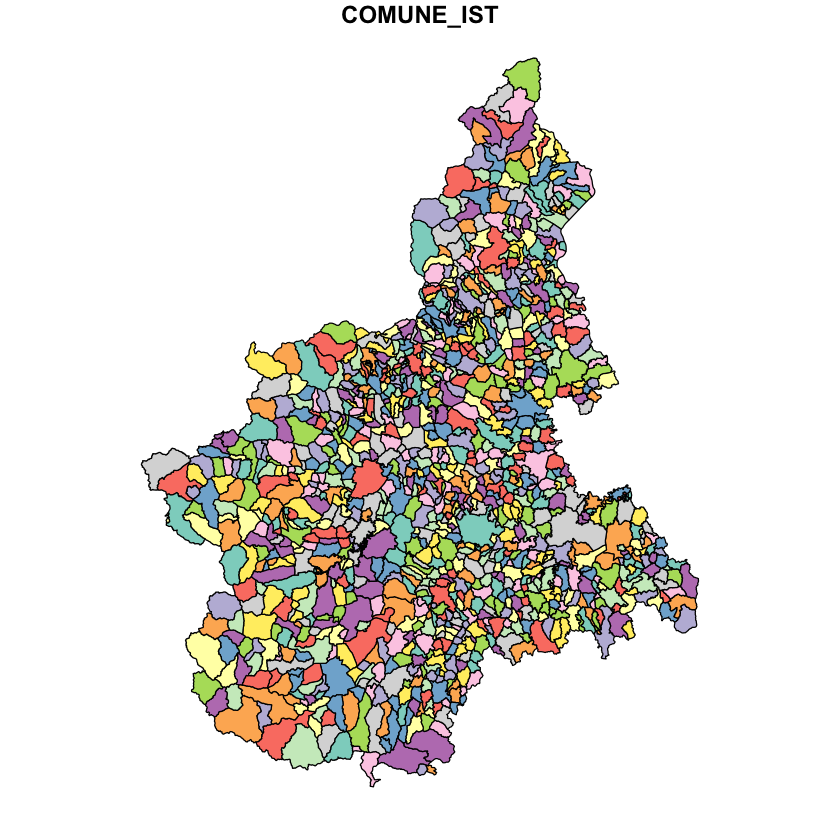

In [23]:
plot(nc_merge[10])